In [2]:
# -------------------------------------------
# 1. 라이브러리 임포트
# -------------------------------------------
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import coint, adfuller
import gym
from gym import spaces
from stable_baselines3 import PPO

try:
    from pykalman import KalmanFilter
except ImportError:
    print("error")
    KalmanFilter = None

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'AppleGothic' # Windows: 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
print("✅ 라이브러리 준비 완료")

✅ 라이브러리 준비 완료


In [4]:
# -------------------------------------------
# 2. 분석 기간 설정 및 데이터 수집
# -------------------------------------------
stock1_name = 'Dow Jones'
stock2_name = 'S&P 500'
stock1_ticker = 'DJI'
stock2_ticker = 'US500'

formation_start = '2023-01-01'
formation_end = '2024-12-31'
trading_start = '2025-01-01'
trading_end = datetime.today().strftime('%Y-%m-%d')

print(f"📈 {stock1_name} & {stock2_name} 데이터를 수집합니다...")
s1_prices = fdr.DataReader(stock1_ticker, formation_start, trading_end)['Close']
s2_prices = fdr.DataReader(stock2_ticker, formation_start, trading_end)['Close']

prices_df = pd.DataFrame({stock1_name: s1_prices, stock2_name: s2_prices}).dropna()

print("\n✅ 데이터 수집 완료")
print(f"형성 기간: {formation_start} ~ {formation_end}")
print(f"백테스트 기간: {trading_start} ~ {trading_end}")

📈 Dow Jones & S&P 500 데이터를 수집합니다...

✅ 데이터 수집 완료
형성 기간: 2023-01-01 ~ 2024-12-31
백테스트 기간: 2025-01-01 ~ 2025-08-30


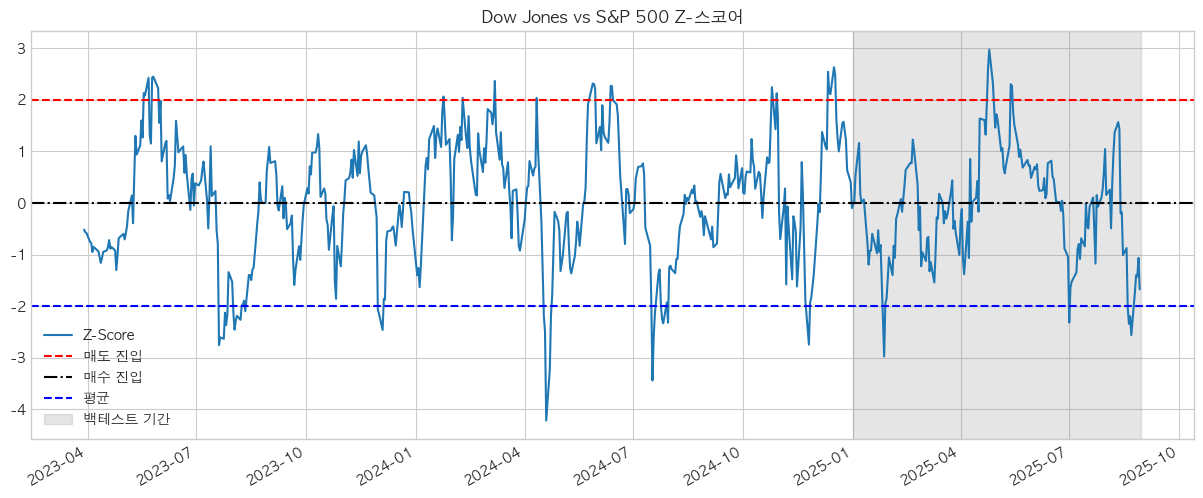

In [7]:
# -------------------------------------------
# 3. 칼만 필터 및 롤링 Z-스코어 계산
# -------------------------------------------
formation_prices = prices_df.loc[formation_start:formation_end]
s1_form = formation_prices[stock1_name]
s2_form = formation_prices[stock2_name]


kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=0.01
)

# 전체 기간에 대해 동적 헤지 비율 추정
s1_full = prices_df[stock1_name]
s2_full = prices_df[stock2_name]
state_means_full, _ = kf.filter((s2_full / s1_full).values)
hedge_ratios_full = pd.Series(state_means_full.flatten(), index=s1_full.index)

# 동적 스프레드 계산
spread_full = s2_full - hedge_ratios_full * s1_full

window = 60 
rolling_mean = spread_full.rolling(window=window).mean()
rolling_std = spread_full.rolling(window=window).std()
zscore_full = (spread_full - rolling_mean) / rolling_std

zscore_train = zscore_full.loc[formation_start:formation_end].dropna()
zscore_test = zscore_full.loc[trading_start:trading_end].dropna()

# Z-스코어 시각화
plt.figure(figsize=(15, 6))
zscore_full.plot(title=f'{stock1_name} vs {stock2_name} Z-스코어', grid=True)
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(0.0, color='black', linestyle='-.')
plt.axhline(-2.0, color='blue', linestyle='--')
plt.axvspan(trading_start, trading_end, color='gray', alpha=0.2, label='백테스트 기간')
plt.legend(['Z-Score', '매도 진입', '매수 진입', '평균', '백테스트 기간'])
plt.show()

In [13]:
# -------------------------------------------
# 4. 강화학습 환경 정의
# -------------------------------------------
class PairTradingEnv(gym.Env):
    def __init__(self, zscore_series, window_size=30, initial_capital=10000000):
        super(PairTradingEnv, self).__init__()
        self.zscore = zscore_series.values
        self.window_size = window_size
        self.initial_capital = initial_capital
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(window_size + 1,), dtype=np.float32)

    def reset(self):
        self.current_step = self.window_size
        self.capital = self.initial_capital
        self.position = 0 # 0: 없음, 1: 매수, -1: 매도
        self.portfolio_values = [self.initial_capital]
        return self._get_obs()

    def _get_obs(self):
        end = self.current_step
        if end >= len(self.zscore): end = len(self.zscore) -1
        obs = self.zscore[end - self.window_size : end]
        position_obs = np.array([self.position])
        return np.concatenate((obs, position_obs)).astype(np.float32)

    def step(self, action):
        done = self.current_step >= len(self.zscore) - 1 or self.capital <= self.initial_capital * 0.5
        if done: return self._get_obs(), 0, True, {}
            
        current_z = self.zscore[self.current_step]
        prev_z = self.zscore[self.current_step-1]
        reward = 0
        
        if self.position == 0:
            if action == 1: self.position = 1
            elif action == 2: self.position = -1
                
        if self.position == 1:
            reward = (current_z - prev_z) * 100000
            if current_z >= 0: self.position = 0
        elif self.position == -1:
            reward = -(current_z - prev_z) * 100000
            if current_z <= 0: self.position = 0
            
        self.capital += reward
        self.portfolio_values.append(self.capital)
        self.current_step += 1
        
        return self._get_obs(), reward, done, {}

print("PairTradingEnv이 성공적으로 정의되었습니다.")

PairTradingEnv이 성공적으로 정의되었습니다.


학습을 시작합니다...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Library/anaconda3/envs/ppp/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 413      |
|    ep_rew_mean     | 3.4e+06  |
| time/              |          |
|    fps             | 1705     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 413           |
|    ep_rew_mean          | 3.43e+06      |
| time/                   |               |
|    fps                  | 1098          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 8.8245724e-07 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.1          |
|    explained_variance   | 7.75e-07      |


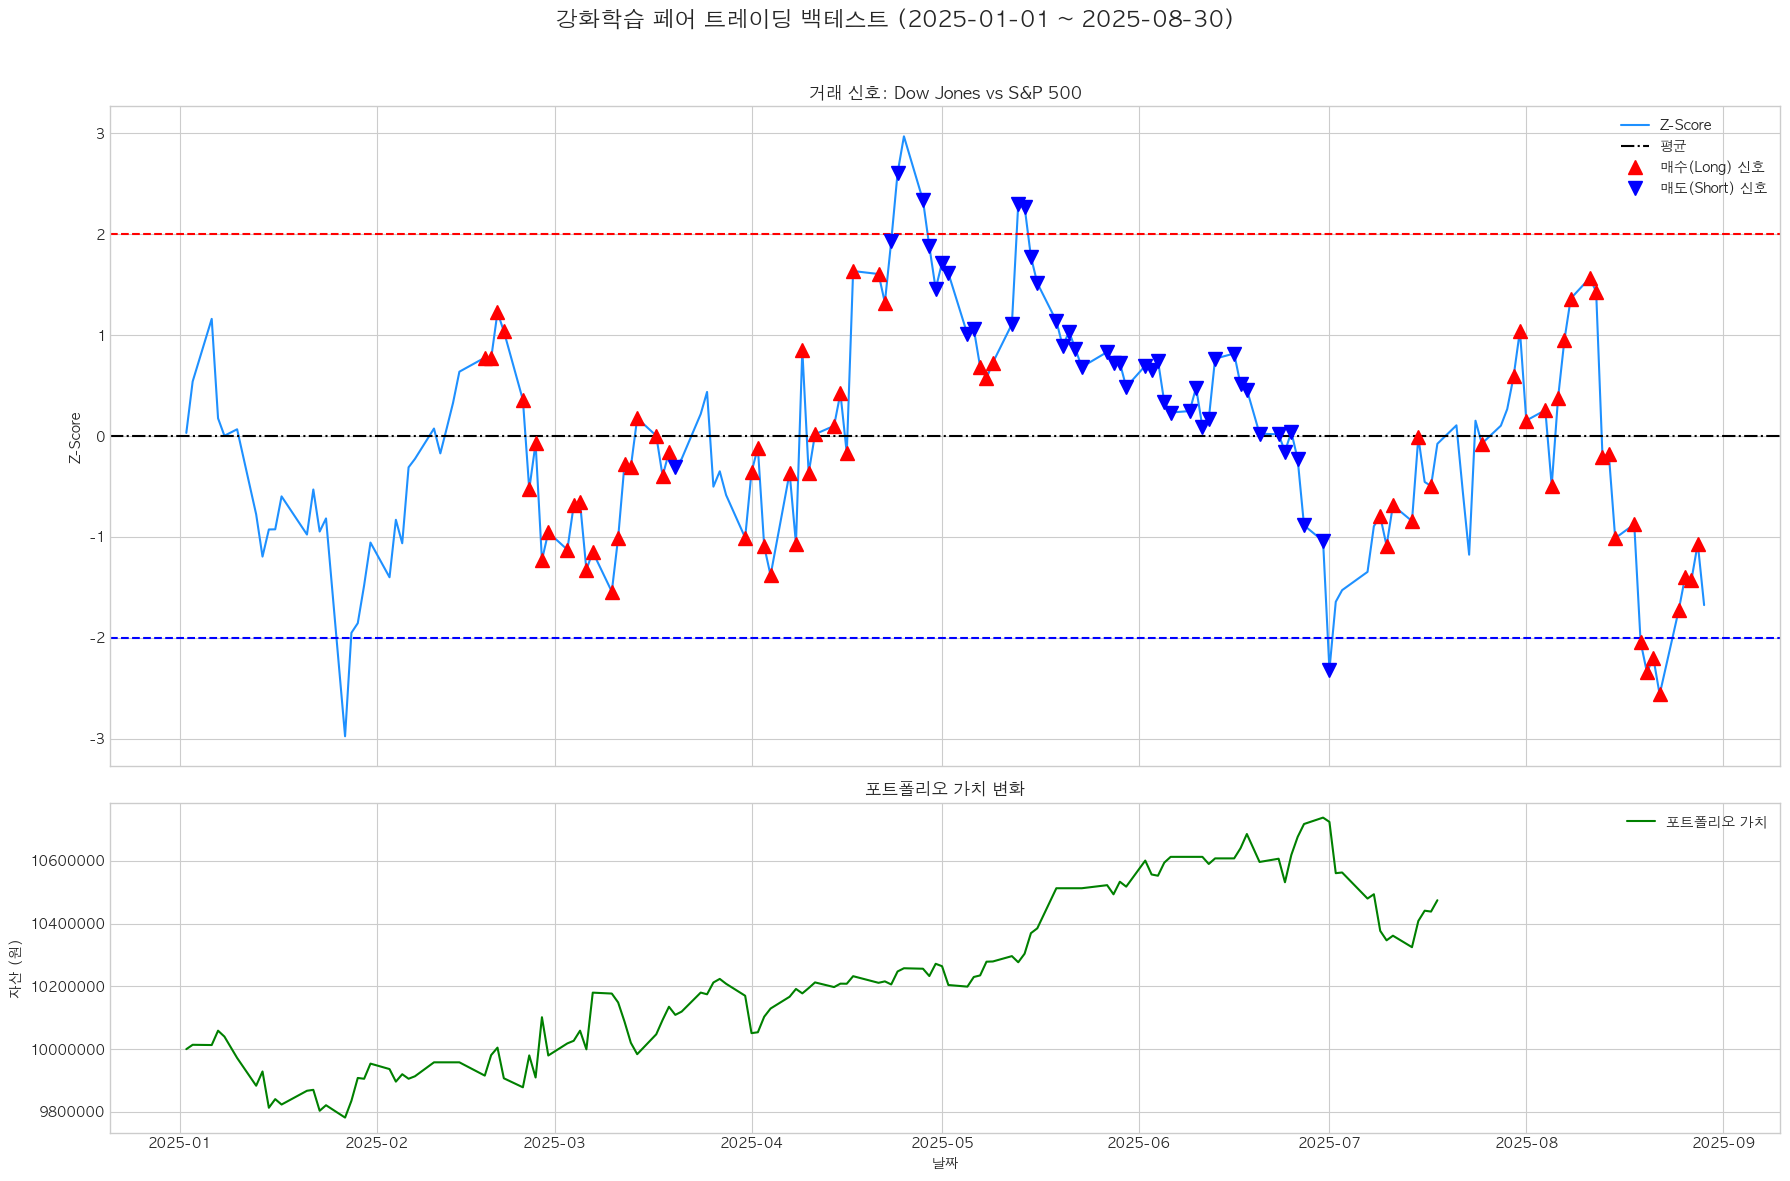


--- 최종 성과 (2025-01-01 ~ 2025-08-30) ---
초기 자본: ₩10,000,000
최종 자본: ₩10,474,506
------------------------------
총 수익률: 4.75%
연환산 수익률: 9.47%
최대 낙폭 (MDD): -3.84%
샤프 지수 (Sharpe Ratio): 1.11


In [18]:
# -------------------------------------------
# 5. 모델 훈련 및 최종 백테스팅
# -------------------------------------------
print("학습을 시작합니다...")
train_env = PairTradingEnv(zscore_train)
model = PPO("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=100000)
print("학습 완료!")

print("백테스팅을 시작합니다...")
test_env = PairTradingEnv(zscore_test)
obs = test_env.reset()
actions_taken = []

for _ in range(len(zscore_test) - test_env.window_size - 1):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, info = test_env.step(action)
    actions_taken.append(int(action))
    if done:
        break
portfolio_history = test_env.portfolio_values

# 결과 시각화
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
fig.suptitle(f'강화학습 페어 트레이딩 백테스트 ({trading_start} ~ {trading_end})', fontsize=16)

trade_indices = zscore_test.index[test_env.window_size:len(actions_taken) + test_env.window_size]
ax1.plot(zscore_test.index, zscore_test.values, label='Z-Score', color='dodgerblue')
ax1.axhline(2.0, color='red', linestyle='--')
ax1.axhline(0.0, color='black', linestyle='-.', label='평균')
ax1.axhline(-2.0, color='blue', linestyle='--')

buy_signals = [i for i, a in enumerate(actions_taken) if a == 1]
sell_signals = [i for i, a in enumerate(actions_taken) if a == 2]

ax1.plot(trade_indices[buy_signals], zscore_test.values[test_env.window_size:-1][buy_signals], '^', markersize=10, color='red', label='매수(Long) 신호')
ax1.plot(trade_indices[sell_signals], zscore_test.values[test_env.window_size:-1][sell_signals], 'v', markersize=10, color='blue', label='매도(Short) 신호')
ax1.set_title(f'거래 신호: {stock1_name} vs {stock2_name}')
ax1.legend()
ax1.set_ylabel('Z-Score')

portfolio_index = zscore_test.index[:len(portfolio_history)]
ax2.plot(portfolio_index, portfolio_history, label='포트폴리오 가치', color='green')
ax2.set_title('포트폴리오 가치 변화')
ax2.legend()
ax2.set_ylabel('자산 (원)')
ax2.ticklabel_format(style='plain', axis='y')

plt.xlabel('날짜')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 상세 성과 지표 계산
portfolio_df = pd.DataFrame({'value': portfolio_history}, index=portfolio_index)
initial_val = portfolio_df['value'].iloc[0]
final_val = portfolio_df['value'].iloc[-1]
total_return = (final_val - initial_val) / initial_val * 100
daily_returns = portfolio_df['value'].pct_change().dropna()

if not daily_returns.empty and daily_returns.std() != 0:
    annualized_return = (1 + daily_returns.mean()) ** 252 - 1
    mdd = (portfolio_df['value'] / portfolio_df['value'].cummax() - 1).min()
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
else:
    annualized_return = mdd = sharpe_ratio = 0

print(f"\n--- 최종 성과 ({trading_start} ~ {trading_end}) ---")
print(f"초기 자본: ₩{initial_val:,.0f}")
print(f"최종 자본: ₩{final_val:,.0f}")
print("-" * 30)
print(f"총 수익률: {total_return:.2f}%")
print(f"연환산 수익률: {annualized_return*100:.2f}%")
print(f"최대 낙폭 (MDD): {mdd*100:.2f}%")
print(f"샤프 지수 (Sharpe Ratio): {sharpe_ratio:.2f}")

에이전트 학습을 시작합니다...
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 413      |
|    ep_rew_mean     | 3.21e+06 |
| time/              |          |
|    fps             | 1242     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 413           |
|    ep_rew_mean          | 3.33e+06      |
| time/                   |               |
|    fps                  | 1018          |
|    iterations           | 2             |
|    time_elapsed         | 4             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 1.6206177e-06 |
|    clip_fraction        | 0             |
|    clip_range     

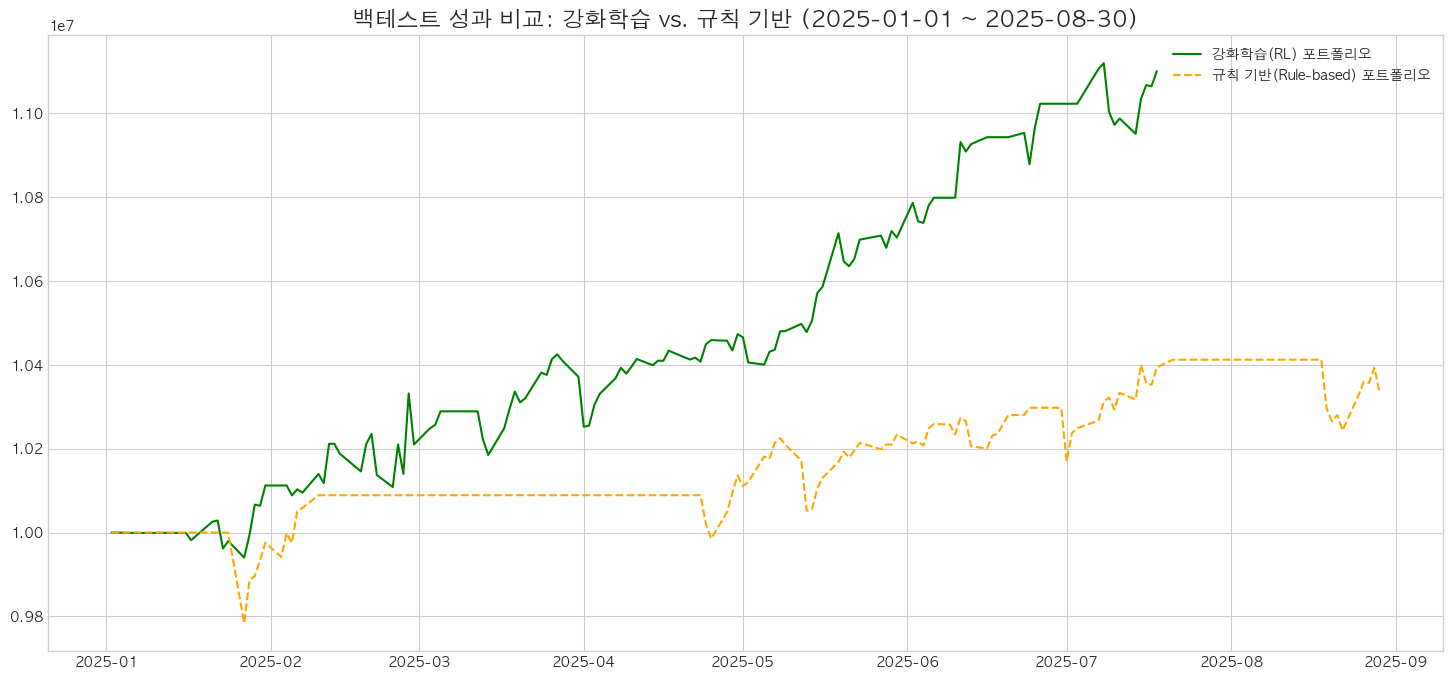


--- 최종 성과 비교 ---
지표              |        강화학습(RL) |    규칙 기반(Rule-based)
----------------------------------------------------------
초기 자본           | ₩   10,000,000 | ₩        10,000,000
최종 자본           | ₩   11,100,401 | ₩        10,332,219
----------------------------------------------------------
총 수익률 (%)       |           11.00 |                 3.32
연환산 수익률 (%)     |           21.98 |                 5.30
최대 낙폭 (MDD) (%) |           -1.66 |                -2.16
샤프 지수           |            2.88 |                 0.96


In [22]:
# -------------------------------------------
# 6. 최종 백테스팅: 규칙 기반 vs. 강화학습 (수정해봄)
# -------------------------------------------
if 'zscore_train' in locals():
    # --- 1. 강화학습 모델 훈련 ---
    print("에이전트 학습을 시작합니다...")
    train_env = PairTradingEnv(zscore_train)
    model = PPO("MlpPolicy", train_env, verbose=1)
    model.learn(total_timesteps=100000)
    print("에이전트 학습 완료")

    # --- 2. 강화학습 모델 백테스팅 ---
    print("RL 에이전트] 백테스팅을 시작합니다...")
    test_env_rl = PairTradingEnv(zscore_test)
    obs_rl = test_env_rl.reset()
    for _ in range(len(zscore_test) - test_env_rl.window_size - 1):
        action, _ = model.predict(obs_rl, deterministic=True)
        obs_rl, _, done, _ = test_env_rl.step(action)
        if done: break
    portfolio_history_rl = test_env_rl.portfolio_values

    # --- 3. 규칙 기반 모델 백테스팅 ---
    print("[규칙 기반] 백테스팅을 시작합니다...")
    initial_capital = 10000000
    portfolio_history_rule = [initial_capital]
    capital = initial_capital
    position = 0
    
    for i in range(1, len(zscore_test)):
        current_z = zscore_test.iloc[i]
        prev_z = zscore_test.iloc[i-1]
        
        # 포지션이 없을 때 진입 규칙
        if position == 0:
            if current_z < -2.0: position = 1  # 매수 진입
            elif current_z > 2.0: position = -1 # 매도 진입
        
        # 포지션이 있을 때 청산 규칙 및 손익 계산
        pnl = 0
        if position == 1: # 매수 포지션
            pnl = (current_z - prev_z) * 100000
            if current_z >= 0: position = 0 # 평균 회귀 시 청산
        elif position == -1: # 매도 포지션
            pnl = -(current_z - prev_z) * 100000
            if current_z <= 0: position = 0 # 평균 회귀 시 청산
        
        capital += pnl
        portfolio_history_rule.append(capital)

    # --- 4. 결과 시각화 및 비교 ---
    portfolio_index_rl = zscore_test.index[:len(portfolio_history_rl)]
    portfolio_index_rule = zscore_test.index[:len(portfolio_history_rule)]
    
    plt.figure(figsize=(18, 8))
    plt.plot(portfolio_index_rl, portfolio_history_rl, label='강화학습(RL) 포트폴리오', color='green')
    plt.plot(portfolio_index_rule, portfolio_history_rule, label='규칙 기반(Rule-based) 포트폴리오', color='orange', linestyle='--')
    plt.title(f'백테스트 성과 비교: 강화학습 vs. 규칙 기반 ({trading_start} ~ {trading_end})', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- 5. 최종 성과표 출력 ---
    def calculate_metrics(history, index):
        df = pd.DataFrame({'value': history}, index=index)
        initial = df['value'].iloc[0]
        final = df['value'].iloc[-1]
        ret = (final - initial) / initial * 100
        returns = df['value'].pct_change().dropna()
        if not returns.empty and returns.std() != 0:
            ann_ret = (1 + returns.mean()) ** 252 - 1
            mdd = (df['value'] / df['value'].cummax() - 1).min()
            sharpe = (returns.mean() / returns.std()) * np.sqrt(252)
        else:
            ann_ret = mdd = sharpe = 0
        return initial, final, ret, ann_ret, mdd, sharpe

    i_rl, f_rl, r_rl, ar_rl, mdd_rl, sh_rl = calculate_metrics(portfolio_history_rl, portfolio_index_rl)
    i_rule, f_rule, r_rule, ar_rule, mdd_rule, sh_rule = calculate_metrics(portfolio_history_rule, portfolio_index_rule)

    print("\n--- 최종 성과 비교 ---")
    print(f"{'지표':<15} | {'강화학습(RL)':>15} | {'규칙 기반(Rule-based)':>20}")
    print("-" * 58)
    print(f"{'초기 자본':<15} | ₩{i_rl:13,.0f} | ₩{i_rule:18,.0f}")
    print(f"{'최종 자본':<15} | ₩{f_rl:13,.0f} | ₩{f_rule:18,.0f}")
    print("-" * 58)
    print(f"{'총 수익률 (%)':<15} | {r_rl:15.2f} | {r_rule:20.2f}")
    print(f"{'연환산 수익률 (%)':<15} | {ar_rl*100:15.2f} | {ar_rule*100:20.2f}")
    print(f"{'최대 낙폭 (MDD) (%)':<15} | {mdd_rl*100:15.2f} | {mdd_rule*100:20.2f}")
    print(f"{'샤프 지수':<15} | {sh_rl:15.2f} | {sh_rule:20.2f}")